(masses_bfr_ntbk)=

# Masses and binary fraction

This tutorial shows how we can use methods available in the [Synthetic](asteca.Synthetic) class to estimate for a given observed cluster:

- The individual stellar masses and their probability of being binary systems,
- the total binary fraction of the cluster, and 
- the different masses associated to the cluster

as detailed in [Synthetic module](synthetic_mod). We start by loading the cluster file and a set of isochrones, and instantiating a synthetic object which we calibrate with the cluster's data:

In [1]:
import asteca
import pandas as pd
import numpy as np

obs_df = pd.read_csv("../_static/cluster.csv")

# Load cluster file
my_cluster = asteca.Cluster(
    ra=obs_df["RA_ICRS"],
    dec=obs_df["DE_ICRS"], 
    mag=obs_df["Gmag"],
    e_mag=obs_df["e_Gmag"],
    color=obs_df["BP-RP"],
    e_color=obs_df["e_BP-RP"],
    verbose=2
)

# Load isochrones
isochs = asteca.Isochrones(
    model='parsec',
    isochs_path="../_static/parsec/",
    mag="Gmag",
    color=("G_BPmag", "G_RPmag"),
    magnitude_effl=6390.7,
    color_effl=(5182.58, 7825.08),
    verbose=2
)

# Create Synthetic cluster object
synthcl = asteca.Synthetic(isochs, seed=457304, verbose=2)

# Calibrate the `synthcl` object
synthcl.calibrate(my_cluster)


Instantiating cluster from data
Columns read   : ra, dec, mag, e_mag, color, e_color
N_stars        : 1998
N_clust_min    : 25
N_clust_max    : 2000
Cluster object generated

Instantiating isochrones
Model          : PARSEC
N_files        : 1
N_mets         : 3
N_ages         : 11
N_isochs       : 2000
z    range     : [0.01, 0.02]
loga range     : [7.0, 9.5]
Magnitude      : Gmag
Color          : G_BPmag-G_RPmag
Isochrone object generated

Instantiating synthetic
Default params : {'met': 0.0152, 'loga': 8.0, 'alpha': 0.09, 'beta': 0.94, 'Rv': 3.1, 'DR': 0.0, 'Av': 0.2, 'dm': 9.0}
Extinction law : CCMO
Diff reddening : uniform
IMF            : chabrier_2014
Max init mass  : 10000
Gamma dist     : D&K
Random seed    : 457304
Synthetic clusters object generated

Calibrated observed cluster
N_stars_obs    : 1998
Max magnitude  : 18.99
Error distribution loaded


For all three analyses mentioned above, the first step is to call the [get_models()](asteca.Synthetic.get_models) method. This method requires two arguments: `model` which is a dictionary of parameters to be fitted and a `model_std` dictionary which contains the uncertainties (standard deviations) associated to each parameter in the `model` dictionary. For example:

In [2]:
# Values for the fundamental parameters associated to the observed cluster
model = {"met": 0.015, "loga": 8., "dm": 8., "Av": 0.05}

# Uncertainties for each fundamental parameter
model_std = {"met": 0.001, "loga": 0.2, "dm": 0.2, "Av": 0.03}

# Call the method
synthcl.get_models(model, model_std)


Generate synthetic models
N_models       : 200
Attributes stored in Synthetic object


```{note}
Notice that some of the parameters in `model_std` have STDDEV values of `0.0`. This means that these parameters are fixed to the values given in the `model` dictionary.
```

This method will store in the `synthcl` object a number of synthetic clusters, sampled from a normal distribution centered on `model` values with STDDEVs taken from the `model_std` values.

After calling this method, the individual stellar masses and binarity, cluster total mass and cluster total binarity fraction can be estimated as described in [Synthetic module](synthetic_mod) and in the examples shown in the following sub-sections.

## Stellar masses

To assign individual primary and secondary masses and probability of belonging to a binary system for each observed star in your cluster, we use the the [stellar_masses()](asteca.Synthetic.stellar_masses) method:

In [3]:
df_masses_bprob = synthcl.stellar_masses()


Stellar masses and binary probabilities estimated


/home/gabriel/Github/ASteCA/ASteCA/asteca/asteca/synthetic.py:543: UserWarning: 
N=16 stars found with no valid photometric data. These will be assigned 'nan' values
for masses and binarity probability
  warnings.warn(


The warning indicates that some observed stars contain invalid photometric data and thus could not be assigned masses.

The returned variable `df_masses_bprob` is a dictionary containing the columns `m1, m1_std, m2, m2_std, binar_prob`. We can print the resulting dictionary as a pandas DataFrame for better visualization:

In [4]:
# As pandas DataFrame for prettier printing
pd.DataFrame(df_masses_bprob)

,m1,m1_std,m2,m2_std,binar_prob
0,0.475763,0.035295,0.279586,0.067059,0.390
1,1.254432,0.080360,0.830701,0.245423,0.890
2,0.546447,0.037103,0.273745,0.103495,0.285
3,0.966029,0.058967,0.538096,0.199374,0.515
4,0.722376,0.038965,0.343896,0.122676,0.225
...,...,...,...,...,...
1993,0.801386,0.048966,NaN,NaN,0.000
1994,0.308210,0.031808,0.149222,0.044584,0.190
1995,0.451486,0.037928,0.220682,0.066663,0.080
1996,0.366232,0.035124,0.232354,0.063876,0.555


These columns represent, for each observed star in the cluster under analysis, estimates for:

- `m1`: primary mass
- `m1_std`: uncertainty of the primary mass
- `m2`: secondary mass (under the assumption that this star is part of a binary system)
- `m2_std`: uncertainty of the secondary mass
- `binar_prob`: probability of being a binary system 

If an observed star has `binar_prob=0`, i.e. a zero probability of being a binary system, then the mass value for its secondary star `m2` is a `NaN` value as no secondary star could be assigned to it. If any observed star contains invalid photometric data, they will be assigned `NaN` values for masses and binarity probability.

For example, we can extract the binary systems from the above dictionary by selecting a probability cut at `binar_prob=0.5` so that observed stars with larger probability values are described as binary systems:

In [5]:
# Mask to identify binary systems given a probability cut value
msk = df_masses_bprob['binar_prob'] > 0.5

# Show only observed stars identified as binary systems
pd.DataFrame(df_masses_bprob)[msk]

,m1,m1_std,m2,m2_std,binar_prob
1,1.254432,0.080360,0.830701,0.245423,0.890
3,0.966029,0.058967,0.538096,0.199374,0.515
7,1.813081,0.121984,0.999085,0.476090,0.975
9,1.995641,0.163849,1.128347,0.508451,1.000
10,1.061322,0.067542,0.757184,0.193500,0.795
...,...,...,...,...,...
1987,0.283780,0.033323,0.166160,0.035100,0.560
1989,1.093348,0.072092,0.892669,0.169837,1.000
1992,1.742363,0.115715,0.880166,0.471464,0.945
1996,0.366232,0.035124,0.232354,0.063876,0.555


We can also show only single systems, were we remove the columns associated to the secondary masses as they serve no purpose for single systems:

In [6]:
# Show only observed stars identified as single systems
pd.DataFrame(df_masses_bprob)[['m1', 'm1_std', 'binar_prob']][~msk]

,m1,m1_std,binar_prob
0,0.475763,0.035295,0.390
2,0.546447,0.037103,0.285
4,0.722376,0.038965,0.225
5,0.797947,0.047588,0.290
6,0.478480,0.035184,0.125
...,...,...,...
1990,0.453772,0.035814,0.290
1991,0.291912,0.030831,0.000
1993,0.801386,0.048966,0.000
1994,0.308210,0.031808,0.190


Finally, we can visualize the identified single and binary systems in a simple CMD:

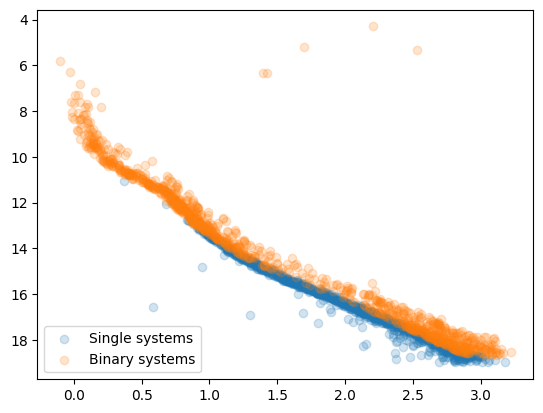

In [7]:
import matplotlib.pyplot as plt
plt.scatter(my_cluster.color[~msk], my_cluster.mag[~msk], alpha=.2, label='Single systems')
plt.scatter(my_cluster.color[msk], my_cluster.mag[msk], alpha=.2, label='Binary systems')
plt.legend()
plt.gca().invert_yaxis();

## Binary fraction

As detailed in [Synthetic module](synthetic_mod), there is no *binary fraction* parameter than can be fitted using the synthetic clusters (as this is handled through the `alpha, beta` parameters). This parameter thus needs to be estimated separately via the [binary_fraction()](asteca.Synthetic.binary_fraction) method as follows:

In [8]:
# Obtain distribution of the total binary fraction
bfr_med, bfr_std = synthcl.binary_fraction(df_masses_bprob['binar_prob'])

Binary fraction: 0.535 +/- 0.009


The only argument required for this method is the distribution of binary probabilities `df_masses_bprob['binar_prob']` obtained in the previous section via the [stellar_masses()](asteca.Synthetic.stellar_masses) method.

The `bfr_med, bfr_std`  variables will store the median and STDDEV values for the total binary fraction estimate for the cluster.

## Cluster mass

As explained in the [Mass and binarity](synthetic_mod) section, **ASteCA** estimates several different masses associated to an observed cluster. These are:

- {math}`M_{init}`: total initial mass (at the moment of cluster's birth)
- {math}`M_{actual}`: actual mass of the cluster (even the low mass portion we do not observe)
- {math}`M_{obs}`: observed mass (sum of individual stellar masses)
- {math}`M_{phot}`: mass **unobserved** due to photometric effects (i.e: the low mass stars beyond the maximum magnitude cut)
- {math}`M_{evol}`: mass **lost** via stellar evolution
- {math}`M_{dyn}`: mass **lost** through dynamical effects (or *dissolution*)

This process is performed via the [cluster_masses()](asteca.Synthetic.cluster_masses) method:

In [9]:
radec_c = (np.median(my_cluster.ra), np.median(my_cluster.dec))
masses_dict = synthcl.cluster_masses(radec_c)


Mass values estimated


The returned dictionary contains arrays with the distributions of masses for each mass described above. Their median and STDDEV values can be extracted for example with:

In [10]:
# Print the median mass values and their STDDEVs
for k, arr in masses_dict.items():
    print("{:<8}: {:.0f}+/-{:.0f}".format(k, np.median(arr), np.std(arr)))

M_init  : 3590+/-450
M_actual: 2553+/-202
M_obs   : 2149+/-127
M_phot  : 369+/-91
M_evol  : 740+/-164
M_dyn   : 311+/-166
